In [15]:
import numpy as np
from ase import io
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from scipy.fftpack import dct

In [8]:
nsteps=10000
timestep=10
nruns=5
runs=np.arange(1,nruns+1)

In [9]:
#Position trajectory is read in. 
#Velocities are computed and the velocity trajectory is returned.

def velTraj(folder, file, calcVel=True):

    traj = []
    traj_read = io.iread(folder + file, format='extxyz')
    for i in range(nsteps):
        traj.append(next(traj_read).get_positions())
    
    if calcVel:
        traj = np.gradient(traj, timestep, axis=0)

    return traj

In [10]:
#The modes of the unit cell are read in.
#The gamma modes for a supercell are built by tiling.

def buildSCmodes(filename, supercell):
    
    modes = np.loadtxt(filename)
    interModes = np.linalg.inv(modes)
    interModes = np.tile(interModes, (1,np.prod(supercell)))/np.sqrt(np.prod(supercell))
    
    return interModes

In [11]:
#Projection of the supercell velocity trajectory onto gamma.

def projTraj(vel, interModes):
    proj_traj = []
    for i in range(nsteps):
        proj_traj.append(interModes@vel[i].flatten())
    proj_traj -= np.average(proj_traj, axis=0)
    
    return proj_traj

In [12]:
folder = './100K/2x2x2/'
filename = 'nve{}.xyz'
supercell = [2,2,2]

#Let's build the gamma modes of the supercell.
interModes = buildSCmodes('./100K/modes', supercell)

proj = {}
for r in runs:
    #We provide an extxyz position trajectory to  the velTraj function.
    vel = velTraj(folder, filename.format(r), calcVel=True)
    #We project the trajectory and store it in the proj dictionary.
    proj[r] = projTraj(vel, interModes)

In [13]:
''' 
Function computing the dynamical VDOS spectrum, i.e. the VDOS is computed along blocks 
of a given trajectory. All the block VDOS for the run are stored in spectra.'''

def blockVDOS(vel_traj, shift, block, npad):

    #The length of the block is given by shift*block_multiple.
    mlag = int(block/2)
    nblocks = int(len(vel_traj)/shift + 1 - (block/shift))

    spectra = np.zeros([nblocks, mlag+npad+1], dtype='float64')
    
    for (n, i) in enumerate(range(0, len(vel_traj)-block+1, shift)):
        
        #Construct timeseries for a given block.
        timeseries = vel_traj[i:i+block]

        #Compute the VDOS spectrum through Fourier trick.
        ft = np.fft.rfft(timeseries, axis=0)
        ac = ft*np.conjugate(ft)
        mean_ac = np.real(np.mean(ac, axis=1))
        autoCorr = np.fft.irfft(mean_ac)[:mlag+1]/np.average(timeseries**2)/block
        corrFT = dct(np.append(autoCorr*np.hanning(block)[mlag-1:], np.zeros(npad)), type=1)
        
        #Store the VDOS of the block.
        spectra[n] = corrFT.real
    
    return spectra

In [16]:
indexes = [3,4,5,6,7,8,9,10,11]

#This dictionary will store, for every r, 
#a numpy array with all the VDOS of all blocks of a given run.
spectra_run = {}

block_shift=200
block_length=4000
npad=10000

for r in runs:
    #First argument is now the velocity traj only of the NM I am interested in.
    spectra_run[r] = blockVDOS(np.take(proj[r], indexes, axis=1), block_shift, block_length, npad)

Text(0.5, 0, '$\\omega [cm^{-1}]$')

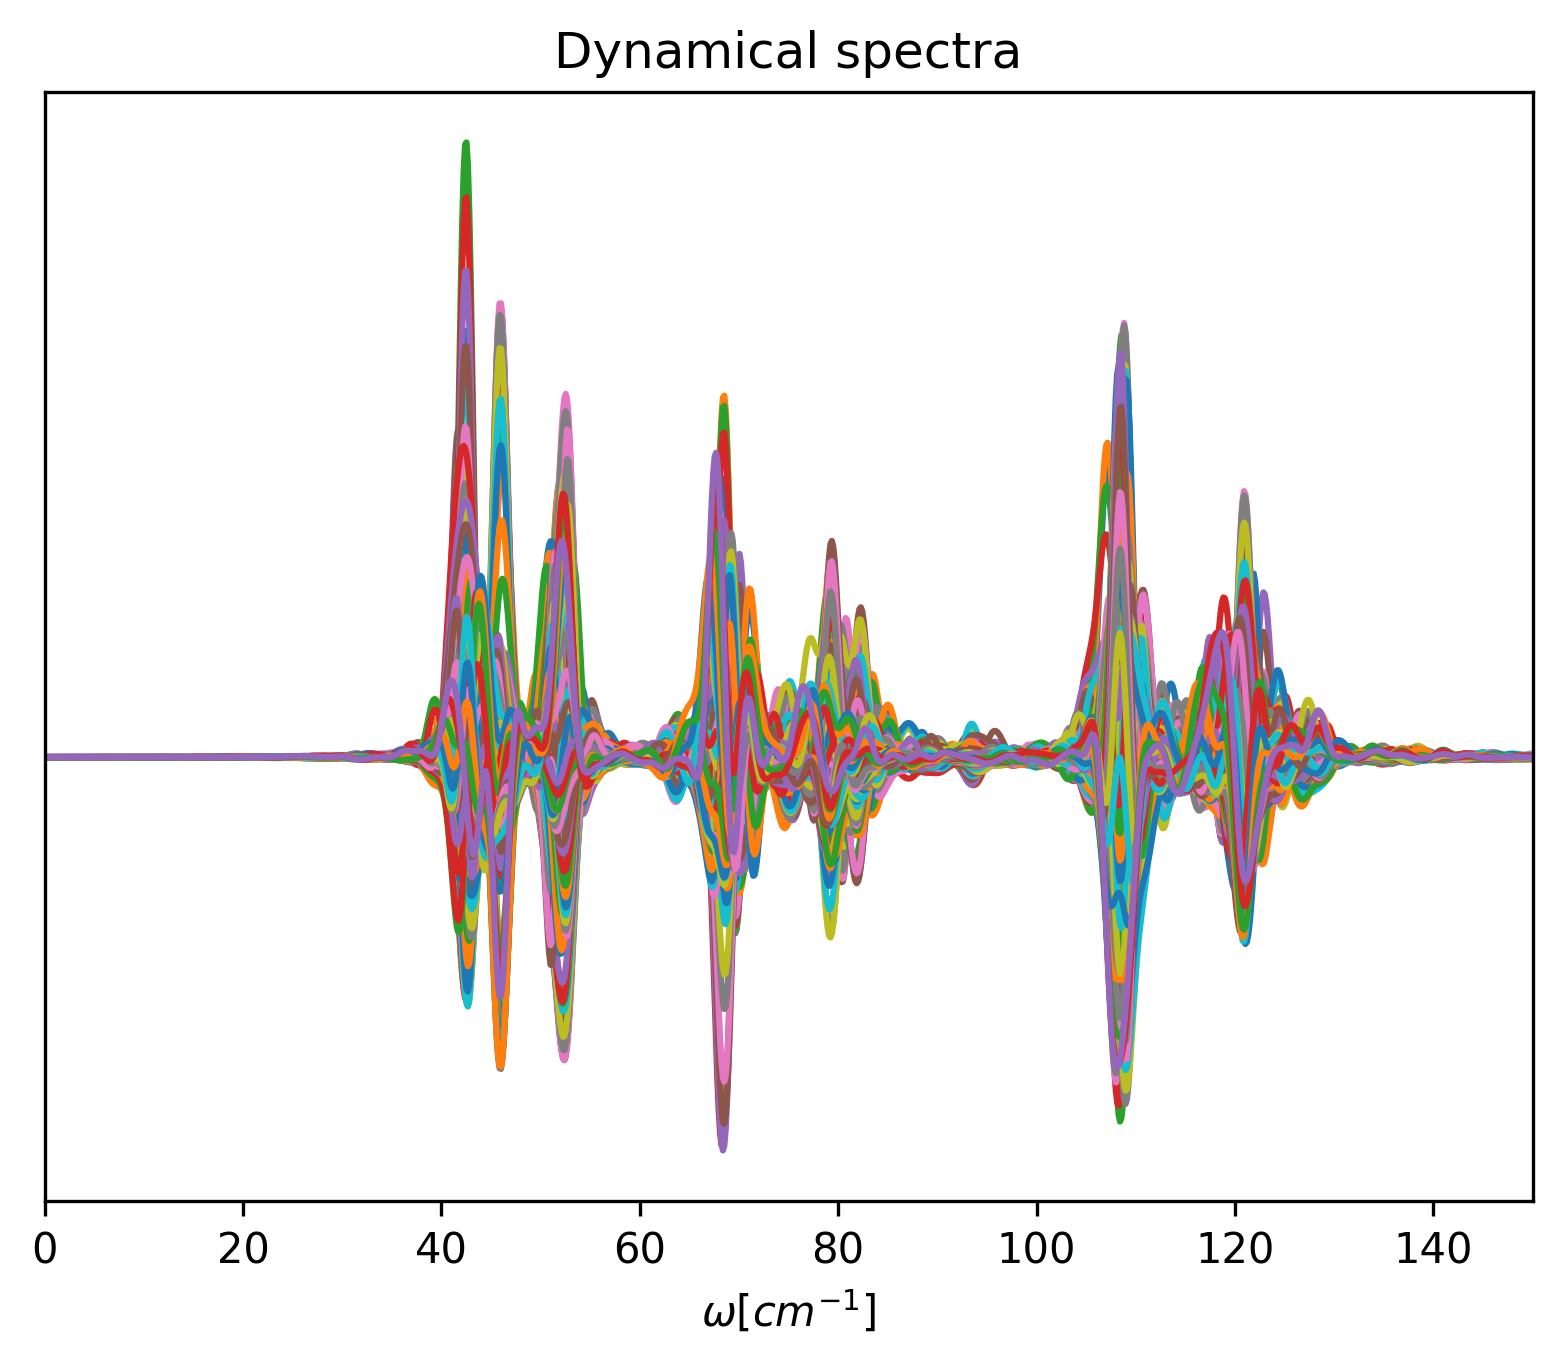

In [17]:
#Frequencies for the x-axis in cm-1
freq = np.fft.rfftfreq(2*int((block_length/2)+npad),timestep)*1000*33.35641 #cm-1
fig = plt.figure(dpi=300.0)

#Here I'm plotting every block VDOS of every run.
for r in runs:
    averageSpectrum = np.average(spectra_run[r],axis=0)
    for i in spectra_run[r]:
        plt.plot(freq, i-averageSpectrum)        

plt.title('Dynamical spectra')
plt.xlim(0,150)
plt.yticks([])
plt.xlabel(r'$\omega [cm^{-1}]$')

In [18]:
for r in runs:
    averageSpectrum = np.average(spectra_run[r], axis=0)
    for (i,spec) in enumerate(spectra_run[r]):
        spectra_run[r][i] = spec-averageSpectrum

In [19]:
spectra_list = [np.array(spectra_run[r], dtype=np.float64) for r in runs]
spectra_array = np.array([np.array(spectra_run[r], dtype=np.float64) for r in runs], dtype=np.float64)

In [20]:
%%time
from numba import jit, prange

@jit(nopython=True, parallel=True)
def compute_intensity(spectra_array, freq_points, nspectra):
    intensity = np.zeros((freq_points, freq_points))

    # Loop over the frequency points
    for j in prange(freq_points):
        for k in prange(freq_points):
            # Loop over each spectrum
            for r in range(spectra_array.shape[0]):
                for i in range(spectra_array.shape[1]):  # Iterate over the second dimension
                    # Subtract the average spectrum to get dynamic spectrum (fluctuations)
                    dyn_spec = spectra_array[r, i]
                    # Compute the correlations at frequencies (j, k)
                    intensity[j, k] += dyn_spec[j] * dyn_spec[k]
    
    intensity /= nspectra - 1
    return intensity

# Example usage
nspectra = len(runs) * len(spectra_list[0])  # Or use the shape of the 3D array
freq_points = 1500
intensity = compute_intensity(spectra_array, freq_points, nspectra)

CPU times: user 3.41 s, sys: 145 ms, total: 3.55 s
Wall time: 1.9 s


Text(0, 0.5, '$\\omega [cm^{-1}]$')

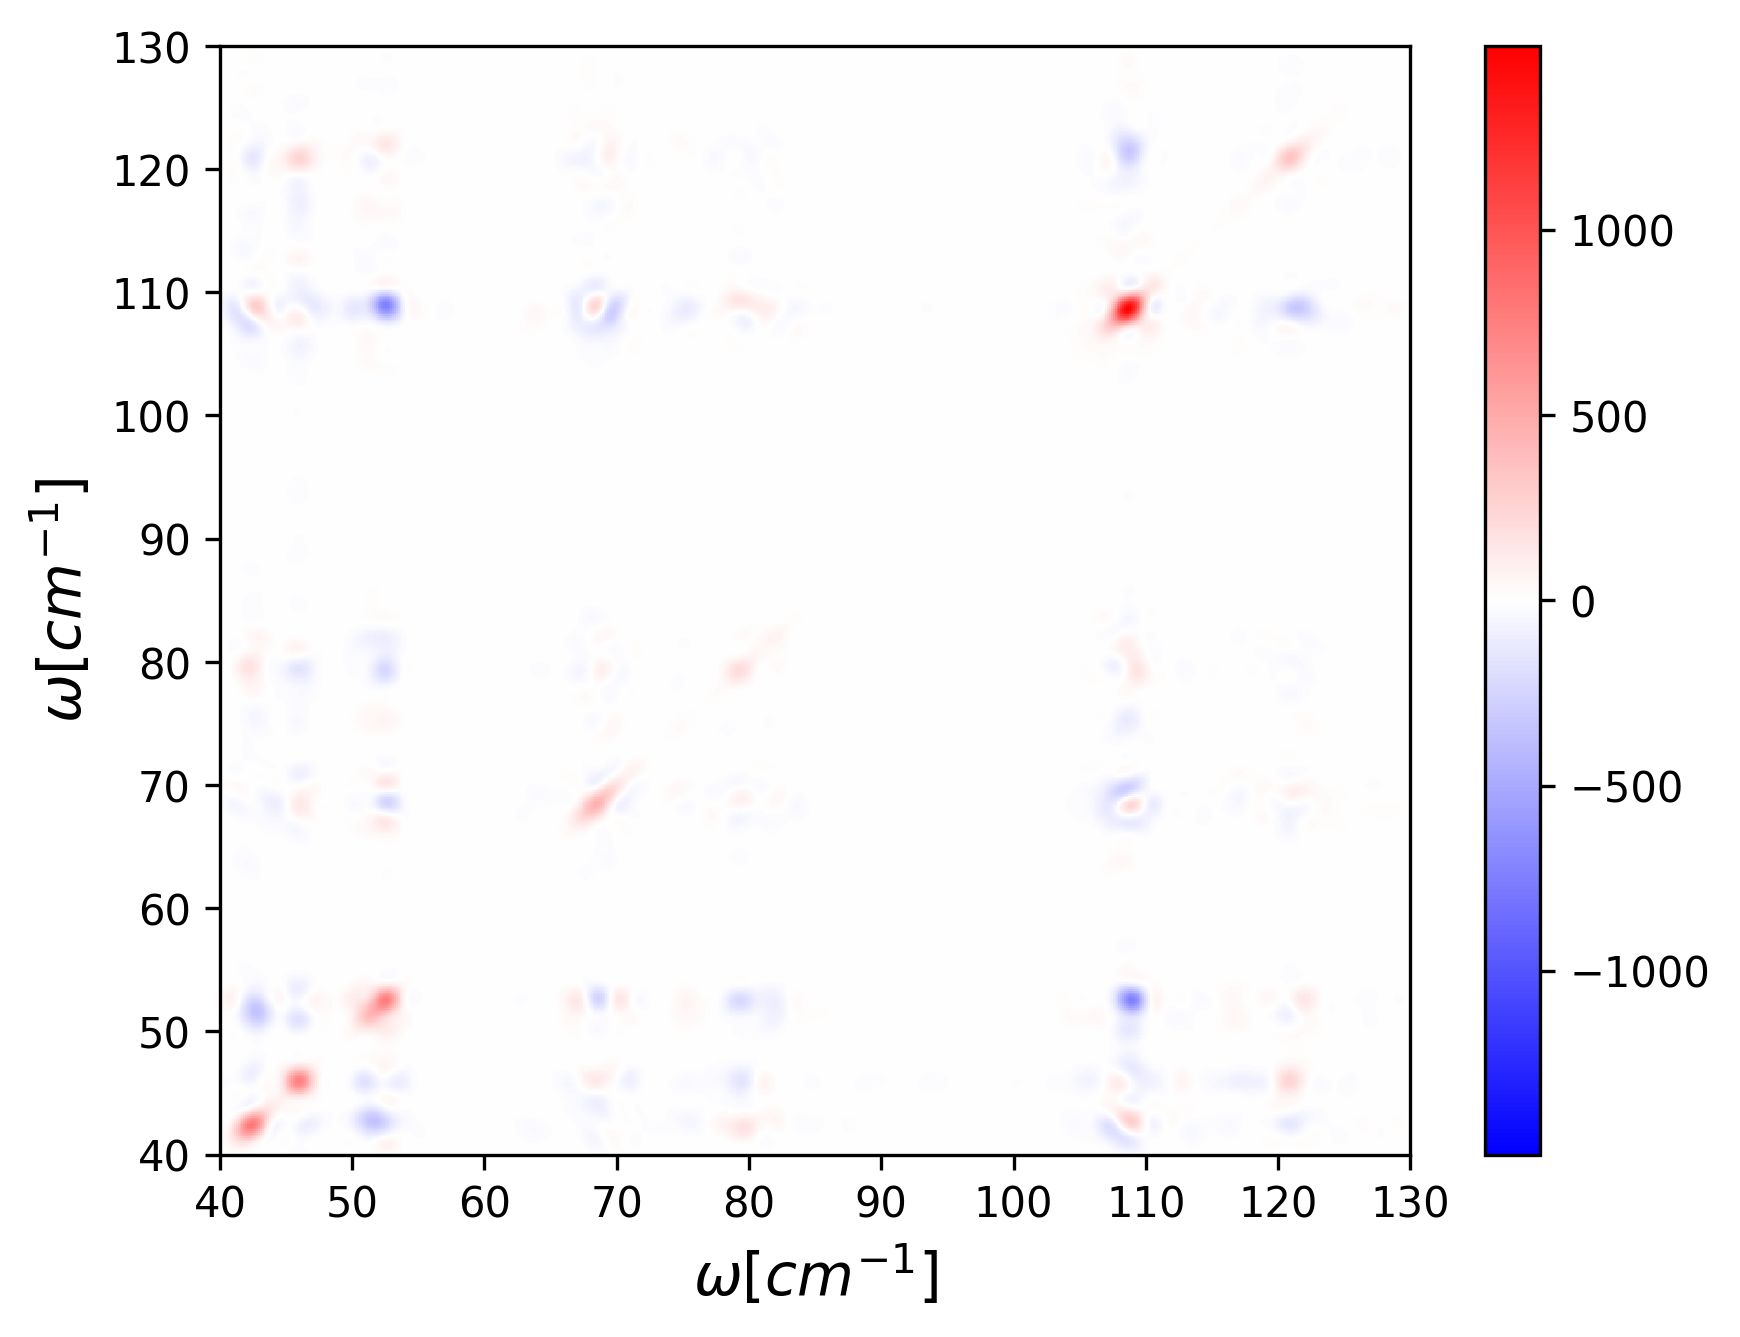

In [21]:
fig = plt.figure(dpi=300.0)
ax = fig.add_subplot(111)
cax = ax.pcolormesh(freq[:1500], freq[:1500], intensity, cmap='bwr', norm=colors.CenteredNorm())
fig.colorbar(cax)

xaxis = np.arange(freq_points)

ax.set_xlim(40,130)
ax.set_ylim(40,130)
ax.set_xlabel(r'$\omega [cm^{-1}]$', fontsize = 14)
ax.set_ylabel(r'$\omega [cm^{-1}]$', fontsize = 14)

#plt.savefig('2D_100K.png')